In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!nvidia-smi

Mon May 27 09:02:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Directories
data_dir = '/content/drive/MyDrive/Colab/112-2-DLA/final/data'
data_dir

'/content/drive/MyDrive/Colab/112-2-DLA/final/data'

In [6]:
config = {
    'train_ratio': 0.8,
    'valid_ratio': 0.1,
    'test_ratio': 0.1,
    'batch_size': 64,
    'num_epochs': 30,
}

In [7]:
# Data transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, data_transforms)
full_dataset

Dataset ImageFolder
    Number of datapoints: 5250
    Root location: /content/drive/MyDrive/Colab/112-2-DLA/final/data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import DataLoader, Subset

# Assuming full_dataset is a torchvision dataset or similar
targets = np.array(full_dataset.targets)  # Extract the target labels

# Define the split ratios
train_ratio, val_ratio = config['train_ratio'], config['valid_ratio']
test_ratio = 1 - train_ratio - val_ratio

# First stratified split to get training set and temporary set (validation + test)
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
train_idx, temp_idx = next(sss_train.split(np.zeros(len(targets)), targets))

# Extract the targets for the temporary set
temp_targets = targets[temp_idx]

# Second stratified split to split the temporary set into validation and test sets
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=620)
val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_targets)), temp_targets))

# Map the indices back to the original dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create the Subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

# Dataloaders and dataset sizes
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Class names
class_names = full_dataset.classes
class_names

['battery',
 'glass',
 'metal',
 'normal plastic',
 'paper',
 'paper container',
 'plastic bottle']

In [9]:
# Model
from torchvision.models import VGG16_Weights

model = models.vgg16(weights=VGG16_Weights.DEFAULT)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 166MB/s]


In [10]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print(f'Best val Acc: {best_val_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Train model
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=config['num_epochs'])


Epoch 0/29


train Loss: 0.9761 Acc: 0.6519


val Loss: 0.4566 Acc: 0.8457
Epoch 1/29


train Loss: 0.4938 Acc: 0.8302


val Loss: 0.3927 Acc: 0.8705
Epoch 2/29


train Loss: 0.4265 Acc: 0.8571


val Loss: 0.3378 Acc: 0.8781
Epoch 3/29


train Loss: 0.3722 Acc: 0.8655


val Loss: 0.3127 Acc: 0.8933
Epoch 4/29


train Loss: 0.3221 Acc: 0.8852


val Loss: 0.2848 Acc: 0.9067
Epoch 5/29


train Loss: 0.2779 Acc: 0.9043


val Loss: 0.2446 Acc: 0.9238
Epoch 6/29


train Loss: 0.2528 Acc: 0.9155


val Loss: 0.2346 Acc: 0.9257
Epoch 7/29


train Loss: 0.2417 Acc: 0.9188


val Loss: 0.2331 Acc: 0.9162
Epoch 8/29


train Loss: 0.2308 Acc: 0.9181


val Loss: 0.2627 Acc: 0.9124
Epoch 9/29


train Loss: 0.2115 Acc: 0.9286


val Loss: 0.2274 Acc: 0.9295
Epoch 10/29


train Loss: 0.1989 Acc: 0.9310


val Loss: 0.2867 Acc: 0.9010
Epoch 11/29


train Loss: 0.1978 Acc: 0.9286


val Loss: 0.2302 Acc: 0.9124
Epoch 12/29


train Loss: 0.1737 Acc: 0.9400


val Loss: 0.2160 Acc: 0.9238
Epoch 13/29


train Loss: 0.1783 Acc: 0.9369


val Loss: 0.2506 Acc: 0.9181
Epoch 14/29


train Loss: 0.1620 Acc: 0.9455


val Loss: 0.1926 Acc: 0.9333
Epoch 15/29


train Loss: 0.1576 Acc: 0.9467


val Loss: 0.1947 Acc: 0.9314
Epoch 16/29


train Loss: 0.1607 Acc: 0.9433


val Loss: 0.2394 Acc: 0.9105
Epoch 17/29


train Loss: 0.1372 Acc: 0.9529


val Loss: 0.2144 Acc: 0.9181
Epoch 18/29


train Loss: 0.1491 Acc: 0.9488


val Loss: 0.2132 Acc: 0.9352
Epoch 19/29


train Loss: 0.1535 Acc: 0.9474


val Loss: 0.1975 Acc: 0.9333
Epoch 20/29


train Loss: 0.1409 Acc: 0.9564


val Loss: 0.1832 Acc: 0.9467
Epoch 21/29


train Loss: 0.1338 Acc: 0.9533


val Loss: 0.1849 Acc: 0.9352
Epoch 22/29


train Loss: 0.1369 Acc: 0.9519


val Loss: 0.1988 Acc: 0.9333
Epoch 23/29


train Loss: 0.1139 Acc: 0.9619


val Loss: 0.2275 Acc: 0.9314
Epoch 24/29


train Loss: 0.1152 Acc: 0.9605


val Loss: 0.1998 Acc: 0.9410
Epoch 25/29


train Loss: 0.1162 Acc: 0.9631


val Loss: 0.2221 Acc: 0.9200
Epoch 26/29


train Loss: 0.1220 Acc: 0.9583


val Loss: 0.2046 Acc: 0.9410
Epoch 27/29


train Loss: 0.1137 Acc: 0.9612


val Loss: 0.2060 Acc: 0.9429
Epoch 28/29


train Loss: 0.0996 Acc: 0.9671


val Loss: 0.1888 Acc: 0.9524
Epoch 29/29


train Loss: 0.1125 Acc: 0.9595


val Loss: 0.1832 Acc: 0.9333
Best val Acc: 0.9524


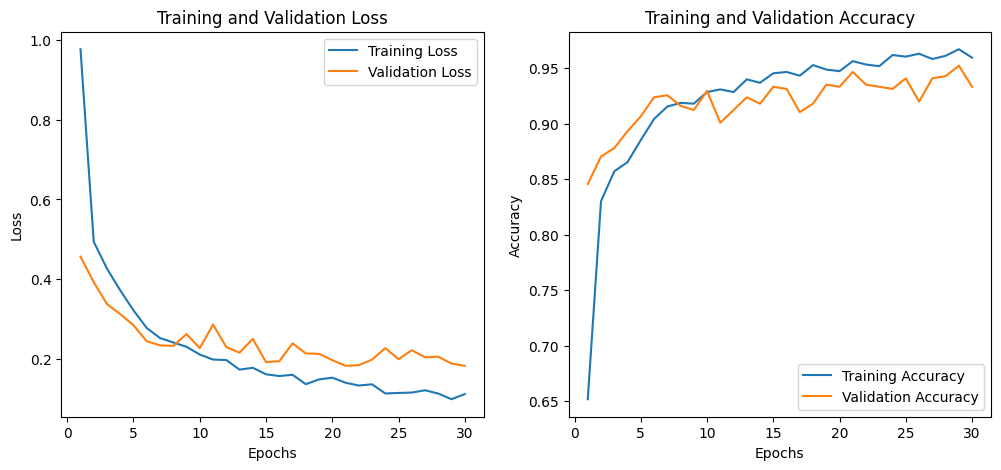

In [11]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Test Loss: 0.2416 Acc: 0.9276


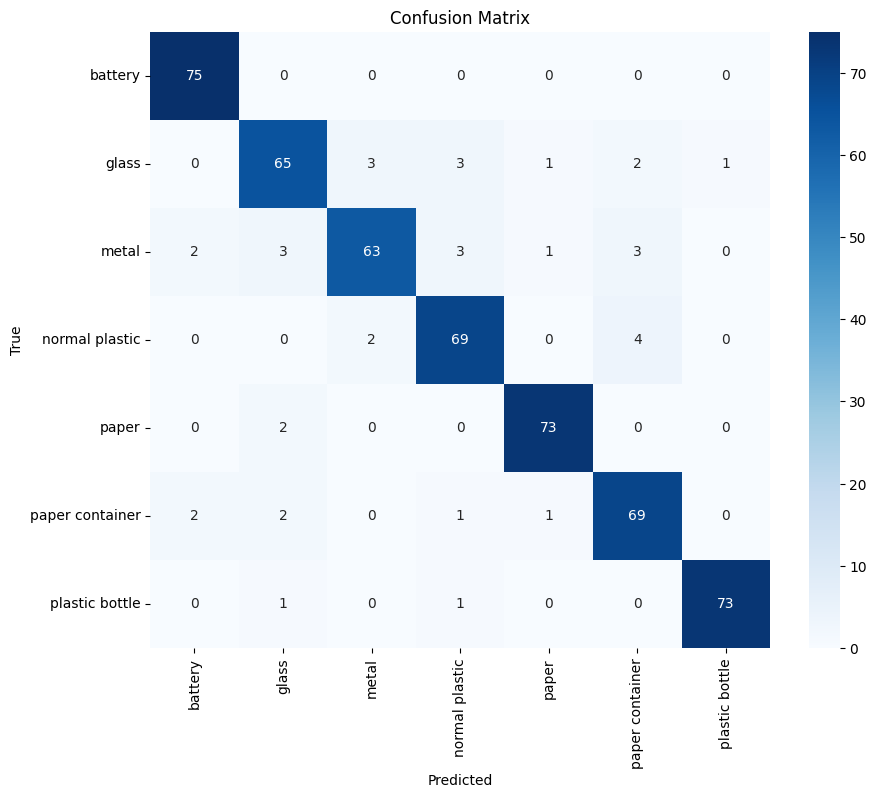


Classification Report:
                 precision    recall  f1-score   support

        battery       0.95      1.00      0.97        75
          glass       0.89      0.87      0.88        75
          metal       0.93      0.84      0.88        75
 normal plastic       0.90      0.92      0.91        75
          paper       0.96      0.97      0.97        75
paper container       0.88      0.92      0.90        75
 plastic bottle       0.99      0.97      0.98        75

       accuracy                           0.93       525
      macro avg       0.93      0.93      0.93       525
   weighted avg       0.93      0.93      0.93       525

Weighted F1 Score: 0.9272
Macro-average F1 Score: 0.9272
Micro-average F1 Score: 0.9276


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Evaluate model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {loss:.4f} Acc: {acc:.4f}')

    return all_labels, all_preds

# Evaluate on the test set
all_labels, all_preds = evaluate_model(model, dataloaders['test'])

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print('\nClassification Report:')
print(class_report)

# F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

# Macro- and Micro-average F1 Scores
macro_f1 = f1_score(all_labels, all_preds, average='macro')
micro_f1 = f1_score(all_labels, all_preds, average='micro')
print(f'Macro-average F1 Score: {macro_f1:.4f}')
print(f'Micro-average F1 Score: {micro_f1:.4f}')

In [13]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/112-2-DLA/final/vgg16.ckpt')